# Setting things up

In [1]:
from general import *
from exp1 import *
import time
import pandas as pd
import multiprocessing as mp

random_state=42
np.random.seed(random_state)
cpu=mp.cpu_count() 
cpu

8

In [2]:
####
alpha=.05 #Significance level
iterations=1 #MC simulations to calculate type-1 error and power
p=20 #Z dim
m=400 #Training set size
n=100 #Test set size
B=100 #Number of permutations/samplings (RESIT,CRT,CPT)
npar = 7 #Number of different values for parameters like gamma, theta, c etc.
nbas = 30 #Number of different generative configurations (different pairs (a,b))

####
iterations2=50
#bas = [[np.random.normal(0, 1, p).reshape(p,1), np.random.normal(0, 1, p).reshape(p,1)] for j in range(nbas)]
skews = [10]
losses = ['mse']

# Experiments

In [3]:
results = {'set':[], 
           'ba':[], 'c':[], 'theta':[], 'skew':[], 'gamma':[], 'loss':[],
           'stfr':[], 'resit':[], 'gcm':[], 'crt':[], 'cpt':[],'rbpt':[], 'rbpt2':[]}

In [4]:
def exp1(it, theta, gamma, c, a, b, skew, m, n, p, loss, alpha, B, 
         tests={'stfr':True, 'resit':True, 'gcm':True, 'crt':True, 'cpt':True,'rbpt':True, 'rbpt2':True}):
    
    #Gen. training data
    Z_train=np.load('/Users/maiapolo/Desktop/research/cdt/data2/Z_train_{:}_{:}.npy'.format(theta,it))
    X_train=np.load('/Users/maiapolo/Desktop/research/cdt/data2/X_train_{:}_{:}.npy'.format(theta,it))
    Y_train=np.load('/Users/maiapolo/Desktop/research/cdt/data2/Y_train_{:}_{:}.npy'.format(theta,it))

    #Gen. test data
    Z_test=np.load('/Users/maiapolo/Desktop/research/cdt/data2/Z_test_{:}_{:}.npy'.format(theta,it))
    X_test=np.load('/Users/maiapolo/Desktop/research/cdt/data2/X_test_{:}_{:}.npy'.format(theta,it))
    Y_test=np.load('/Users/maiapolo/Desktop/research/cdt/data2/Y_test_{:}_{:}.npy'.format(theta,it))
            
    #Fitting models
    g1 = g()
    g1.fit(X_train, Z_train, Y_train)
    g2 = g()
    g2.fit(None, Z_train, Y_train)
    g3 = g()
    g3.fit(None, Z_train, X_train)
                
    #STFR
    if tests['stfr']: reject_stfr = (get_pval_stfr(X_test, Z_test, Y_test, g1, g2, loss=loss) <= alpha)
    else: reject_stfr = np.nan
        
    #RESIT
    if tests['resit']: reject_resit = (get_pval_resit(X_test, Z_test, Y_test, g2, g3, B=B) <= alpha)
    else: reject_resit = np.nan
        
    #GCM  
    if tests['gcm']: reject_gcm = (get_pval_gcm(X_test, Z_test, Y_test, g2, g3) <= alpha)
    else: reject_gcm = np.nan
        
    #CRT
    if tests['crt']: reject_crt = get_pval_crt(X_test, Z_test, Y_test, b, g1, g2, theta, B, loss=loss)<= alpha
    else: reject_crt = np.nan   
        
    #CPT
    if tests['cpt']: reject_cpt = get_pval_cpt(X_test, Z_test, Y_test, b, g1, g2, theta, B, loss=loss) <= alpha
    else: reject_cpt = np.nan
        
    #RBPT
    if tests['rbpt']: reject_rbpt = get_pval_rbpt(X_test, Z_test, Y_test, b, g1, theta, loss=loss) <= alpha
    else: reject_rbpt = np.nan
        
    #RBPT2
    if tests['rbpt2']: 
        h = GridSearchCV(KernelRidge(kernel='poly'), cv=2, n_jobs=1,
                      param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                                  "degree": [2]})
        h.fit(Z_train, g1.predict(X_train,Z_train).squeeze())
        reject_rbpt2 = get_pval_rbpt2(X_test, Z_test, Y_test, g1, h, loss=loss)  <= alpha
    else: reject_rbpt2 = np.nan
        
    #Output
    return [reject_stfr, reject_resit, reject_gcm, reject_crt, reject_cpt, reject_rbpt, reject_rbpt2] 


In [ ]:
count=0
it=0
for it2 in tqdm(range(iterations2)):
    for skew in skews:
        for loss in losses:
        
            #### Type I error ####
            c = 0
            
            #CRT,CPT,RBPT#
            tests={'stfr':False, 'resit':False, 'gcm':False, 'crt':True, 'cpt':True,'rbpt':True, 'rbpt2':False}
            thetas = np.linspace(0,6,npar)
            gamma = 0
            for theta in thetas:
                # Running
                a=np.load('/Users/maiapolo/Desktop/research/cdt/data2/a_{:}_{:}.npy'.format(theta,it2))
                b=np.load('/Users/maiapolo/Desktop/research/cdt/data2/b_{:}_{:}.npy'.format(theta,it2))
                out = [exp1(it2, theta, gamma, c, a, b, skew, m, n, p, loss, alpha, B, tests)]
                out = np.array(out).mean(axis=0)
                
                # Storing results
                results['set'].append('type1_2')
                results['ba'].append(count); results['c'].append(c); results['theta'].append(theta); results['skew'].append(skew); results['gamma'].append(gamma); results['loss'].append(loss) 
                results['stfr'].append(out[0]); results['resit'].append(out[1]); results['gcm'].append(out[2]); results['crt'].append(out[3]); results['cpt'].append(out[4]); results['rbpt'].append(out[5]); results['rbpt2'].append(out[6])
        
        
           
    count+=1

 60%|██████    | 30/50 [00:57<00:38,  1.92s/it]

In [ ]:
results = pd.DataFrame(results)
results

## Saving results

In [12]:
plt.figure(figsize=(.9*8,1*2))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplot(1, 2, 1)
        plot_type1(results, sett='type1_1', skew=skew, loss=loss, alpha=alpha, xlabel='$\gamma$', ylabel='Type-1 error', legend=True)
        plt.subplot(1, 2, 2)
        plot_type1(results, sett='type1_2', skew=skew, loss=loss, alpha=alpha, xlabel='$\\theta$', ylabel='Type-1 error', legend=True)
        plt.savefig('plots/exp1_type1_{:}_{:}.png'.format(str(skew),loss), bbox_inches='tight', dpi=300, transparent=True)
        plt.show()

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       ])

In [13]:

#results.to_csv('results/artificial_data_experiments.csv')

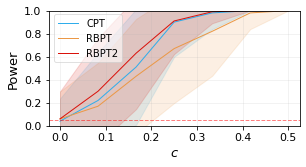

In [14]:
for skew in skews:
    for loss in losses:

        ###
        plt.figure(figsize=(.9*5,1*2))
        plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
        plt.subplot(1, 1, 1)
        plot_power(results, skew=skew, loss=loss, alpha=alpha, xlabel='$c$', ylabel='Power', legend=True)
        #plt.savefig('plots/exp1_power_{:}_{:}.png'.format(str(skew),loss), bbox_inches='tight', dpi=300, transparent=True)
        plt.show()